In [27]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score


### Downloading, Filtering, and Cleaning Data
(this is specific to andrews implentation. sophias cleans it a bit different and doesnt run off the clean data file so that code is down by her executable)

In [14]:
#  Downloaded data and made sure its viewable
df = pd.read_csv("flight_data_2018_2024.csv")
# df.head()
# print(df[['CRSDepTime', 'CRSElapsedTime', 'Distance']].head())

# Select only relevant features
features = [
    'Year', 'Month', 'DayOfWeek', 'Marketing_Airline_Network', 'Origin', 'Dest',
    'Distance', 'DepDelay', 'ArrDelay', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime',
    'Cancelled', 'Diverted', 'ArrDelayMinutes'
]
df_filtered = df[features].copy()

# Remove cancelled and diverted flights
# this is because for SVP, we want delay severity (classification problem) and if a flight is cancelled or diverted then this col doesnt get a value 
#   and for MLP, we are looking at cost-per-mile and a canceled flight doesnt fly (distance is meaningless) and a diverted flight wont have a reliable distance to calculate with
df_filtered = df_filtered[(df_filtered['Cancelled'] == 0) & (df_filtered['Diverted'] == 0)]

# Define delay severity classification
def classify_delay(mins):
    if mins < -5:
        return "Early" # minimum val for arrDelayMin col is 0 but in case we switch to using the other arrDelay col, this is here
    elif mins <= 15:
        return "On-Time"
    elif mins <= 60:
        return "Moderate"
    else:
        return "Severe"

# Fill NAs and create classification label
df_filtered['ArrDelayMinutes'] = df_filtered['ArrDelayMinutes'].fillna(0)
df_filtered['DelaySeverity'] = df_filtered['ArrDelayMinutes'].apply(classify_delay)

# Remove zero or missing distances before cost calculation
df_filtered = df_filtered[df_filtered['Distance'] > 0]

# Compute cost per mile (proxy formula)
# Cost per mile = CRSElapsedTime * some airline cost multiplier / Distance
df_filtered['CostPerMile'] = (df_filtered['CRSElapsedTime'] * 0.2) / df_filtered['Distance']

# Final cleanup of unused cols
df_final = df_filtered.drop(columns=['Cancelled', 'Diverted'])

# Save to CSV
df_final.to_csv("cleaned_flight_data.csv", index=False)
print("Cleaned dataset saved as 'cleaned_flight_data.csv'")


/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_47727/3811188444.py:2: DtypeWarning: Columns (11,13,86,93,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flight_data_2018_2024.csv")


Cleaned dataset saved as 'cleaned_flight_data.csv'



### Delay Prediction (binary classification)
#### SVM 
by andrew

In [15]:
# set df to use new file
df = pd.read_csv("cleaned_flight_data.csv")

# Let's do some basic EDA
# EDA to help with Feature Engineering
print("Original Cleaned")
unique_airlines = df['Marketing_Airline_Network'].unique()

n=25000

airline_counts = df['Marketing_Airline_Network'].value_counts()
eligible_airlines = airline_counts[airline_counts >= n].index

# Run a SVM on a sample subset of each airline
for eachAirline in eligible_airlines:
    print(eachAirline + " data:")
    df_temp = df[df['Marketing_Airline_Network'] == eachAirline].copy()
    df_sample = df_temp.sample(n=n, random_state=42)

    categorical_cols = ['Marketing_Airline_Network', 'Origin', 'Dest']
    df_sample = pd.get_dummies(df_sample, columns=categorical_cols, drop_first=True)

    # Encode target label
    le = LabelEncoder()
    df_sample['DelaySeverity'] = le.fit_transform(df_sample['DelaySeverity'])

    # Define features and target
    X_svp = df_sample.drop(columns=['DelaySeverity', 'CostPerMile'])
    y_svp = df_sample['DelaySeverity']

    # Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X_svp, y_svp, test_size=0.2, stratify=y_svp, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVP model with class balancing
    svp_model = SVC(kernel='rbf', C=1.0, class_weight='balanced')
    svp_model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = svp_model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # check how balanced the predictions are
    unique, counts = np.unique(y_pred, return_counts=True)
    print(dict(zip(le.inverse_transform(unique), counts)))
    print("=====================================================================================")
    print()






Original Cleaned
AA data:
              precision    recall  f1-score   support

    Moderate       0.57      0.79      0.66       763
     On-Time       0.96      0.87      0.92      3684
      Severe       0.74      0.82      0.77       553

    accuracy                           0.85      5000
   macro avg       0.76      0.83      0.78      5000
weighted avg       0.88      0.85      0.86      5000

{'Moderate': 1051, 'On-Time': 3335, 'Severe': 614}

DL data:
              precision    recall  f1-score   support

    Moderate       0.55      0.83      0.66       586
     On-Time       0.98      0.88      0.93      4015
      Severe       0.68      0.86      0.76       399

    accuracy                           0.87      5000
   macro avg       0.74      0.86      0.78      5000
weighted avg       0.90      0.87      0.88      5000

{'Moderate': 895, 'On-Time': 3602, 'Severe': 503}

WN data:
              precision    recall  f1-score   support

    Moderate       0.72      0.90   

### Delay Prediction
#### MLP (sophias first one)

(cleaning the data specifically for sophias implementation)

In [20]:
#  Downloaded data and made sure its viewable
dfs = pd.read_csv("flight_data_2018_2024.csv")
# Clean the data (get rid of any duplicates or NA)
dfs.isnull().sum()


# Forward filling missing values across all columns
dfs.fillna(method='ffill', inplace=True)

# Verify that there are no more missing values
print(dfs.isnull().sum())

# Getting rid of any missing extra columns now
dfs.dropna(axis=1, inplace = True)
print(dfs.isnull().sum())

/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_47727/3633208181.py:2: DtypeWarning: Columns (11,13,86,93,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.read_csv("flight_data_2018_2024.csv")
/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_47727/3633208181.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfs.fillna(method='ffill', inplace=True)


Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
                     ...  
Div5LongestGTime    582425
Div5WheelsOff       582425
Div5TailNum         582425
Duplicate                0
Unnamed: 119        582425
Length: 120, dtype: int64
Year                  0
Quarter               0
Month                 0
DayofMonth            0
DayOfWeek             0
                     ..
NASDelay              0
SecurityDelay         0
LateAircraftDelay     0
DivAirportLandings    0
Duplicate             0
Length: 67, dtype: int64


In [ ]:


dfs['Cancelled'] = dfs['Cancelled'].astype(int)

dfs['CRSDepHour'] = dfs['CRSDepTime'] // 100

# One-hot encode categorical columns
categorical_cols = ['OriginState', 'DestState']
dfs = pd.get_dummies(dfs, columns=categorical_cols)

# Update the 'string_columns' list after one-hot encoding
string_columns = dfs.select_dtypes(include='object').columns

# Drop the original categorical columns that are not one-hot encoded
dfs = dfs.drop(columns=string_columns)

# The one-hot encoded columns remain in the dataframe after pd.get_dummies
print(dfs.columns)



scaler = StandardScaler()
scaled_features = ['CRSDepHour', 'CRSElapsedTime', 'Distance']

dfs[scaled_features] = scaler.fit_transform(dfs[scaled_features])

# Features and columns
X = dfs.drop(columns=['Cancelled'])
y = dfs['Cancelled']

/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_47727/3976833865.py:2: DtypeWarning: Columns (11,13,86,93,94,101) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = pd.read_csv("flight_data_2018_2024.csv")
/var/folders/1q/01y_4h4d165c7y939z_0hrf00000gq/T/ipykernel_47727/3976833865.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dfs.fillna(method='ffill', inplace=True)


Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
                     ...  
Div5LongestGTime    582425
Div5WheelsOff       582425
Div5TailNum         582425
Duplicate                0
Unnamed: 119        582425
Length: 120, dtype: int64
Year                  0
Quarter               0
Month                 0
DayofMonth            0
DayOfWeek             0
                     ..
NASDelay              0
SecurityDelay         0
LateAircraftDelay     0
DivAirportLandings    0
Duplicate             0
Length: 67, dtype: int64
Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline',
       'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline',
       'OriginAirportID',
       ...
       'DestState_TT', 'DestState_TX', 'DestState_UT', 'DestState_VA',
       'DestState_VI', 'DestState_VT', 'DestState_WA', 'DestState_WI',
       

/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 6s 740us/step - accuracy: 0.9487 - loss: 394.2999 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 2/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 662us/step - accuracy: 0.9621 - loss: 0.3076 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 3/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 649us/step - accuracy: 0.9625 - loss: 0.2057 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 4/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 648us/step - accuracy: 0.9623 - loss: 0.1667 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 5/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step - accuracy: 0.9616 - loss: 0.1960 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 6/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 642us/step - accuracy: 0.9622 - loss: 0.1773 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 7/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 634us/step - accuracy: 0.9621 - loss: 0.1829 - val_accuracy: 0.9621 - val_loss: 0.1612
Epoch 8/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step - accuracy: 0.9616

/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

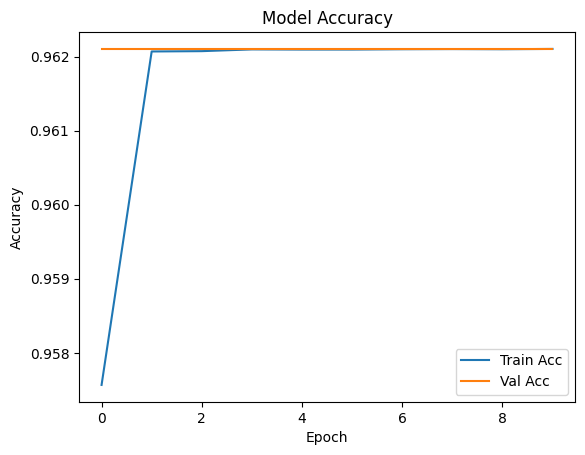

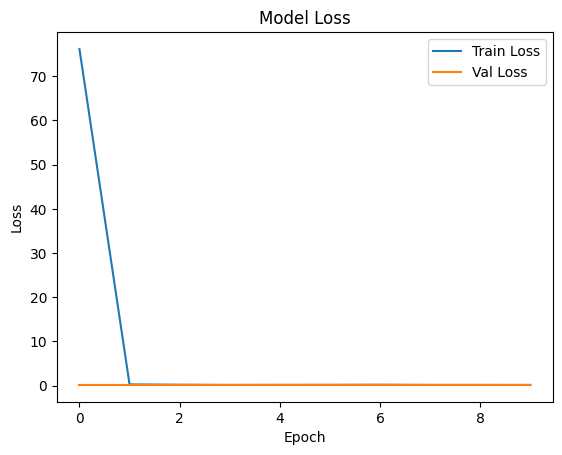

In [21]:
# MLP (but still for binary classification) -- an alternate implementation of the SVM classifier above

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Build the model
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 3. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, callbacks=[early_stopping])

# Predict on test set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot acccuracy Graphs

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Now do it for delay times - Make a threshold. Time series -RNN model as well. Graph and plot. EDA plots. Poster Monday.


### Delay Prediction
#### MLP (sophias second one)

Epoch 1/20


/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 688us/step - accuracy: 0.5686 - loss: 1509.2799 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 2/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 667us/step - accuracy: 0.5988 - loss: 0.9596 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 3/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 644us/step - accuracy: 0.5980 - loss: 0.6888 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 4/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 663us/step - accuracy: 0.5964 - loss: 0.8066 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 5/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 646us/step - accuracy: 0.5976 - loss: 0.6938 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 6/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 660us/step - accuracy: 0.5985 - loss: 0.6843 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 7/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 639us/step - accuracy: 0.5967 - loss: 0.6746 - val_accuracy: 0.5976 - val_loss: 0.6740
Epoch 8/20
7281/7281 ━━━━━━━━━━━━━━━━━━━━ 5s 655us/step - accuracy: 0.5987 - loss: 0

/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrew/Desktop/Flight Project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

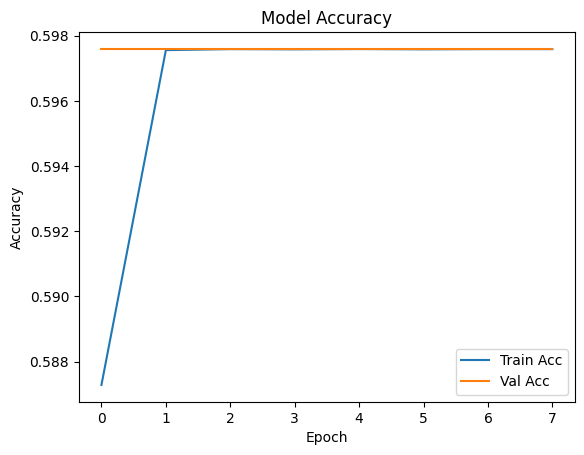

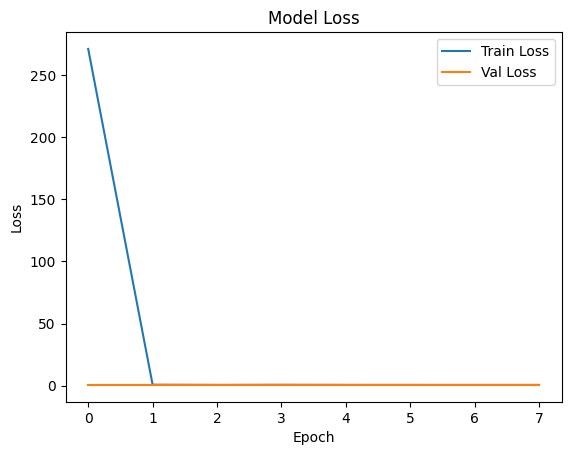

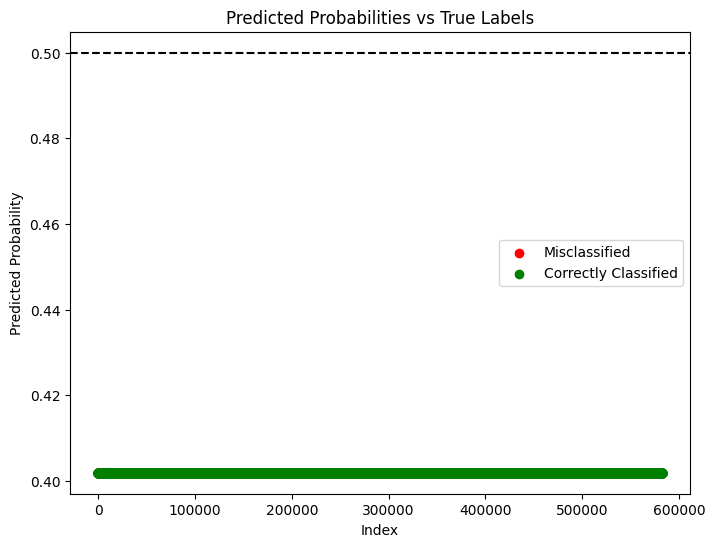

In [22]:
# MLP (but still for binary classification) -- an alternate implementation of the SVM classifier above

# Step 1: Preprocess
dfs['CRSDepHour'] = dfs['CRSDepTime'] // 100

# One-hot encode categorical columns
categorical_cols = ['OriginState', 'DestState']
dfs = pd.get_dummies(dfs, columns=categorical_cols)

# Drop non-one-hot string columns
string_columns = dfs.select_dtypes(include='object').columns
dfs = dfs.drop(columns=string_columns)

# Scale numerical features
scaler = StandardScaler()
scaled_features = ['CRSDepHour', 'CRSElapsedTime', 'Distance']
dfs[scaled_features] = scaler.fit_transform(dfs[scaled_features])

# Step 2: Create a binary delay category
dfs['DelayBinary'] = (dfs['ArrDelay'] > 0).astype(int)  # 1 for delayed, 0 for on-time

# Features
X = dfs.drop(columns=['Cancelled', 'ArrDelay', 'DepDelay', 'DelayBinary'])

# Target variable (DelayBinary)
y = dfs['DelayBinary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# 2. Build the model
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# 3. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64, callbacks=[early_stopping])

# Predict on test set
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot acccuracy Graphs

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Visualize the predicted probabilities vs true labels
df_results = pd.DataFrame({
    'True Label': y_test,
    'Predicted Probability': y_pred_prob,
    'Predicted Label': y_pred
})

# Plot a few misclassified examples
misclassified = df_results[df_results['True Label'] != df_results['Predicted Label']]

plt.figure(figsize=(8, 6))
plt.scatter(misclassified.index, misclassified['Predicted Probability'], color='red', label='Misclassified')
plt.scatter(df_results[df_results['True Label'] == df_results['Predicted Label']].index, 
            df_results[df_results['True Label'] == df_results['Predicted Label']]['Predicted Probability'], 
            color='green', label='Correctly Classified')
plt.axhline(0.5, color='black', linestyle='--')
plt.title('Predicted Probabilities vs True Labels')
plt.xlabel('Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()


### Cost per mile regression
#### MLP 
by andrew

UA RMSE: 0.0045
R² Score: 0.9677
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
312632  2024      1          1     693.0      -6.0      -9.0           135.0   
396388  2024      1          7     589.0       5.0     -11.0           106.0   
412212  2024      1          1     401.0      -5.0     -10.0            97.0   
383370  2024      1          4     414.0       4.0      -3.0           108.0   
348434  2024      1          1     748.0      -1.0     -29.0           161.0   
...      ...    ...        ...       ...       ...       ...             ...   
326186  2024      1          2     913.0     -13.0     -30.0           161.0   
334997  2024      1          5     199.0      -5.0     -17.0            68.0   
383063  2024      1          4     679.0      11.0     -12.0           138.0   
364360  2024      1          2    1162.0      91.0      67.0           185.0   
404936  2024      1          5     612.0      -6.0     -10.0           135.0   

      

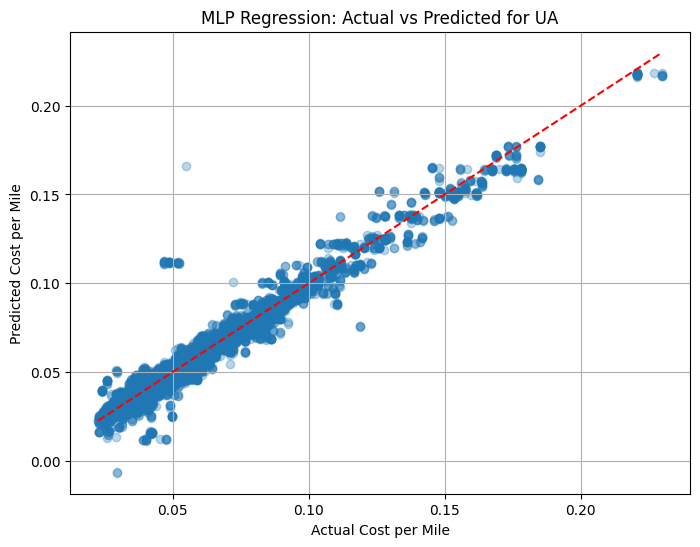


WN RMSE: 0.0111
R² Score: 0.1994
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
81488   2024      1          7     228.0      -1.0     -12.0            70.0   
112528  2024      1          3     577.0       8.0      -5.0           105.0   
76884   2024      1          6     307.0      22.0      21.0            75.0   
51827   2024      1          5     409.0     123.0     193.0            95.0   
59815   2024      1          6     100.0       0.0       0.0            45.0   
...      ...    ...        ...       ...       ...       ...             ...   
101787  2024      1          1     764.0       2.0      -7.0           135.0   
76463   2024      1          6    1235.0      19.0       1.0           170.0   
37402   2024      1          1     323.0      -6.0     -26.0            85.0   
44400   2024      1          3     646.0       4.0     -13.0           115.0   
108419  2024      1          2    1381.0       2.0      72.0           250.0   

     

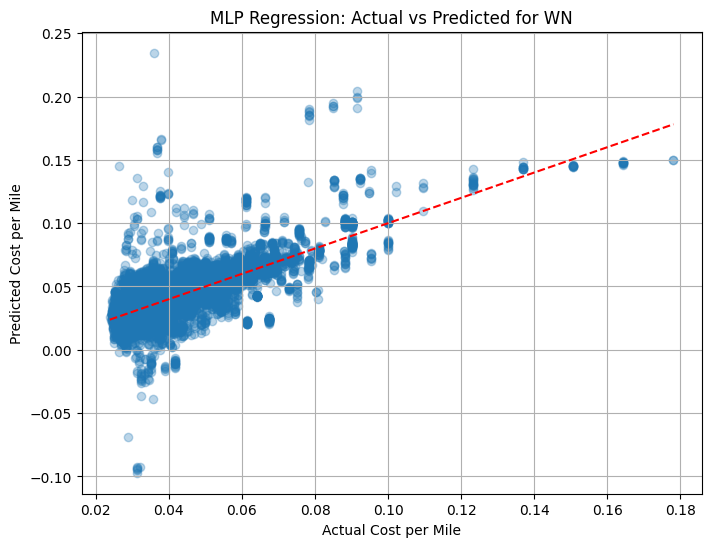


AA RMSE: 0.0056
R² Score: 0.9414
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
486213  2024      1          1    1916.0       2.0     -28.0           295.0   
514891  2024      1          7     119.0     -13.0      18.0            73.0   
512938  2024      1          1     212.0      -9.0     -25.0            84.0   
514243  2024      1          4     119.0       1.0     -12.0            71.0   
449573  2024      1          7     868.0      36.0      53.0           140.0   
...      ...    ...        ...       ...       ...       ...             ...   
504667  2024      1          3    1300.0      90.0      82.0           178.0   
441544  2024      1          7    1916.0       2.0      17.0           297.0   
341740  2024      1          2    1330.0      -1.0      10.0           221.0   
444652  2024      1          2     255.0      -9.0     -16.0            74.0   
254674  2024      1          5     309.0      62.0      57.0            81.0   

     

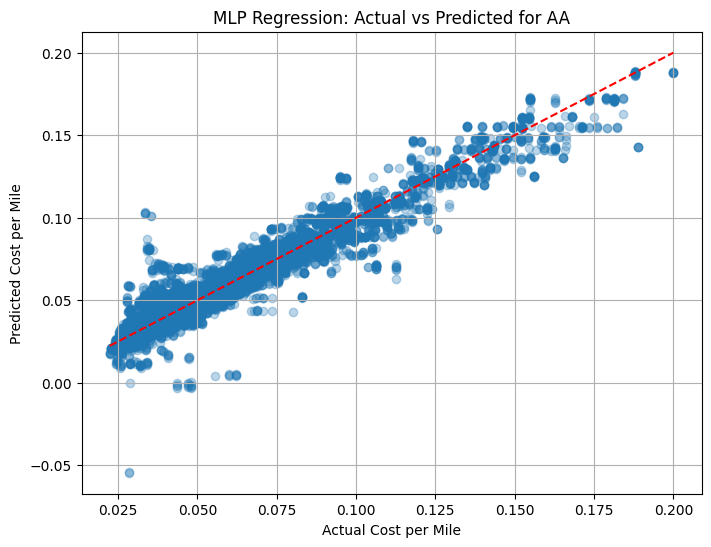


DL RMSE: 0.0073
R² Score: 0.8397
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
309036  2024      1          4     622.0      -4.0      -4.0           135.0   
205538  2024      1          3     481.0       0.0     -12.0           114.0   
148191  2024      1          4    2153.0      -7.0     -23.0           284.0   
195662  2024      1          5     214.0      -3.0      -9.0            67.0   
215104  2024      1          4     591.0      70.0      86.0           112.0   
...      ...    ...        ...       ...       ...       ...             ...   
167420  2024      1          1     341.0      -4.0       4.0            83.0   
189366  2024      1          7    1541.0      14.0       7.0           202.0   
133182  2024      1          5     496.0     -12.0      -7.0           108.0   
214765  2024      1          5    1416.0       6.0     -12.0           205.0   
197428  2024      1          3     907.0       3.0     -18.0           151.0   

     

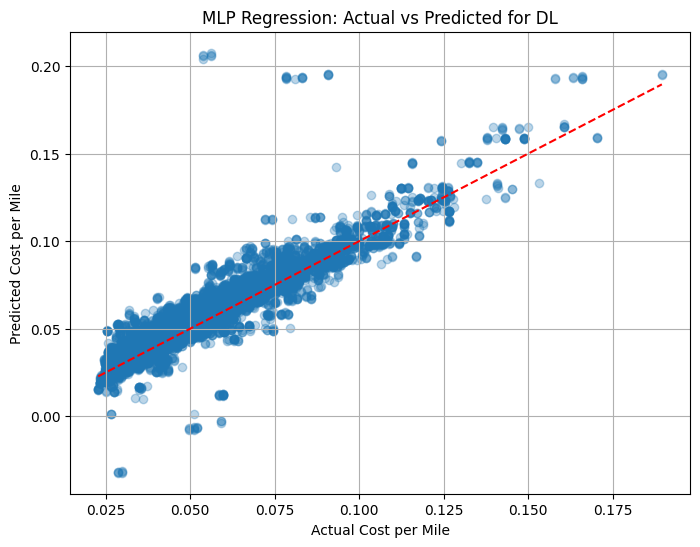


B6 RMSE: 0.0205
R² Score: -0.9948
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
550734  2024      1          5     760.0      23.0       8.0           136.0   
548426  2024      1          1    1185.0      17.0      28.0           205.0   
140710  2024      1          5     759.0       9.0      -5.0           155.0   
550506  2024      1          4     184.0      -8.0     -29.0            85.0   
551852  2024      1          7     818.0     -10.0      -7.0           161.0   
...      ...    ...        ...       ...       ...       ...             ...   
554123  2024      1          3    1237.0      -7.0     -29.0           195.0   
142717  2024      1          1    2475.0     -13.0     -21.0           322.0   
557950  2024      1          3     944.0      -7.0      -2.0           160.0   
548093  2024      1          7     857.0       0.0     -22.0           145.0   
554847  2024      1          5    1249.0      -3.0     -23.0           194.0   

    

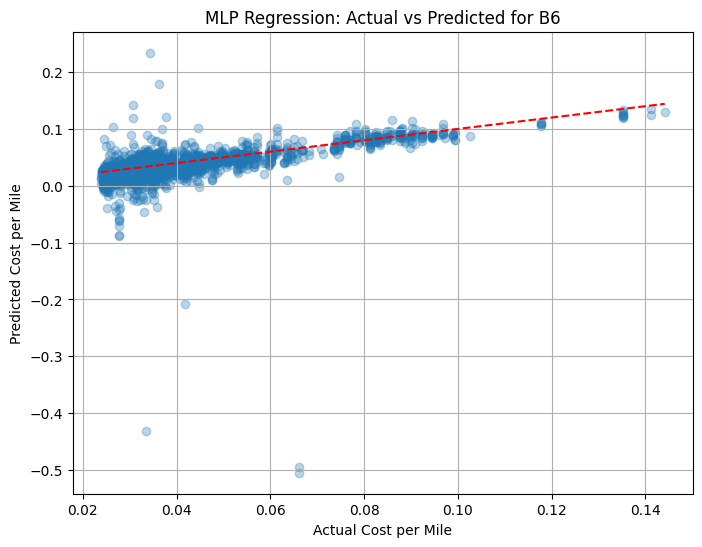


F9 RMSE: 0.0464
R² Score: -28.2803
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
227114  2024      1          3    2057.0      89.0      65.0           282.0   
230900  2024      1          2     854.0       7.0       2.0           170.0   
229340  2024      1          6     391.0      -9.0     -38.0           109.0   
228589  2024      1          4     951.0      -3.0      -6.0           166.0   
226302  2024      1          2     414.0      45.0      38.0           114.0   
...      ...    ...        ...       ...       ...       ...             ...   
229019  2024      1          2     406.0       7.0       0.0            93.0   
222949  2024      1          1     993.0     -15.0     -28.0           162.0   
219217  2024      1          3     534.0      -6.0     -16.0           110.0   
223189  2024      1          4     985.0     -14.0     -24.0           189.0   
224208  2024      1          7     628.0      -1.0      -6.0           122.0   

   

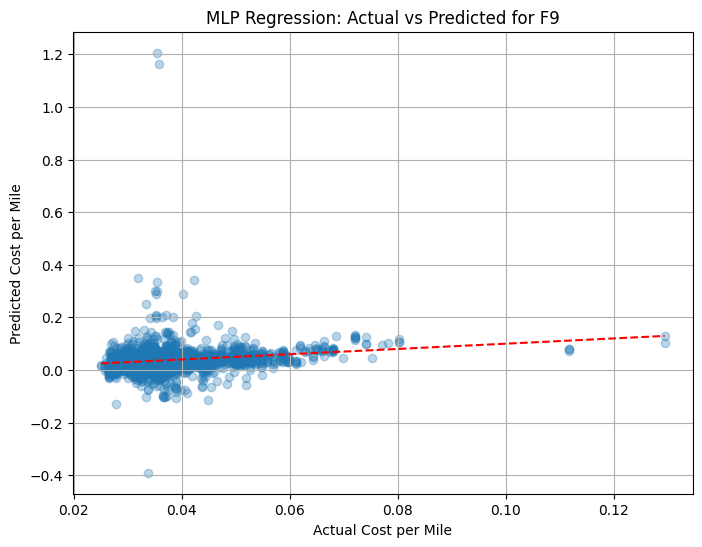


G4 RMSE: 0.0393
R² Score: -68.9778
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
234556  2024      1          7     341.0      12.0      -2.0           101.0   
238974  2024      1          7    1447.0       7.0       2.0           225.0   
237198  2024      1          5     950.0      -7.0     -16.0           135.0   
237931  2024      1          7    1599.0     -12.0     -50.0           272.0   
238774  2024      1          7     656.0      -9.0      -6.0           113.0   
...      ...    ...        ...       ...       ...       ...             ...   
234115  2024      1          5    1090.0       3.0     -16.0           162.0   
234492  2024      1          1     477.0     -11.0     -22.0           110.0   
237107  2024      1          5    1733.0      -7.0     -21.0           235.0   
237648  2024      1          5    1733.0      57.0      40.0           235.0   
232808  2024      1          1    1170.0     -15.0     -18.0           193.0   

   

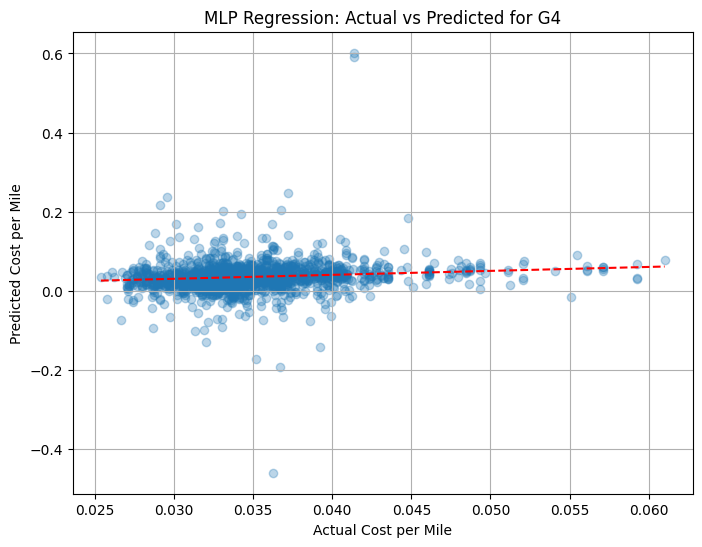


HA RMSE: 0.0211
R² Score: 0.1139
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
242605  2024      1          7     216.0      -7.0      -2.0            53.0   
242925  2024      1          1     201.0      -5.0      -6.0            47.0   
243555  2024      1          5     102.0      -1.0       8.0            42.0   
240861  2024      1          3    2614.0      28.0      11.0           380.0   
246003  2024      1          2     102.0      -4.0      -8.0            38.0   
...      ...    ...        ...       ...       ...       ...             ...   
245413  2024      1          4      84.0       2.0       0.0            38.0   
244678  2024      1          3     163.0      27.0      23.0            48.0   
244761  2024      1          1     100.0      10.0       6.0            43.0   
246747  2024      1          2     100.0      11.0      14.0            39.0   
241457  2024      1          2    2562.0      -1.0      -2.0           365.0   

     

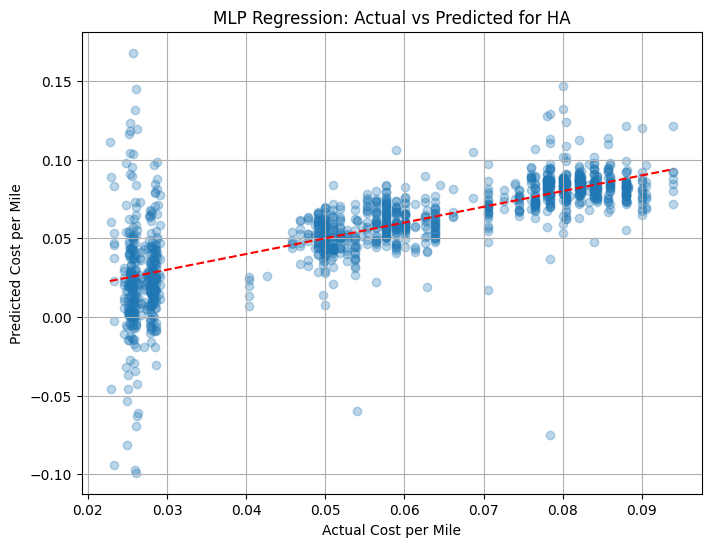


NK RMSE: 0.0167
R² Score: -1.8967
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
283524  2024      1          6     551.0      -4.0      -8.0           106.0   
271874  2024      1          7     787.0      -9.0     -22.0           150.0   
284696  2024      1          2     319.0      -4.0     -19.0            93.0   
275457  2024      1          6     957.0      -6.0       2.0           168.0   
272590  2024      1          4     957.0      -2.0      16.0           168.0   
...      ...    ...        ...       ...       ...       ...             ...   
282006  2024      1          2     977.0      -6.0      -4.0           160.0   
280930  2024      1          2     936.0      -4.0      -3.0           162.0   
269618  2024      1          7     551.0      43.0      38.0           112.0   
269333  2024      1          2    1182.0      95.0     116.0           196.0   
274061  2024      1          5     632.0      -2.0      -7.0           130.0   

    

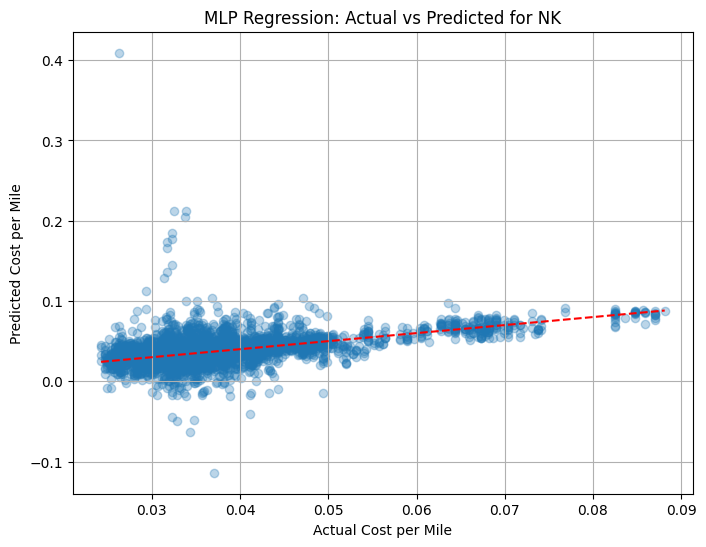


AS RMSE: 0.0184
R² Score: -0.1235
        Year  Month  DayOfWeek  Distance  DepDelay  ArrDelay  CRSElapsedTime  \
538796  2024      1          4    1008.0      -2.0      -3.0           178.0   
533400  2024      1          7    1024.0      36.0      15.0           191.0   
523820  2024      1          1    1399.0       0.0     -17.0           256.0   
535050  2024      1          4    1164.0     -10.0      -1.0           192.0   
531263  2024      1          2     571.0      -9.0     -20.0           102.0   
...      ...    ...        ...       ...       ...       ...             ...   
542525  2024      1          4     261.0      12.0       2.0            69.0   
537889  2024      1          3    1715.0      -8.0     -36.0           265.0   
536683  2024      1          1    2350.0      -4.0     -25.0           358.0   
524980  2024      1          3    2552.0       4.0       2.0           330.0   
349081  2024      1          1     480.0      43.0      43.0           104.0   

    

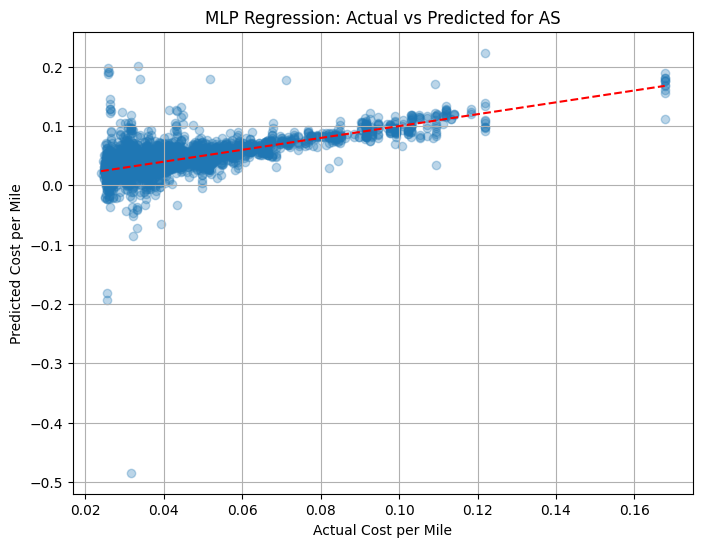

In [ ]:
# set df to use new file
df = pd.read_csv("cleaned_flight_data.csv")

unique_airlines = df['Marketing_Airline_Network'].unique()

for eachAirline in unique_airlines:
    df_temp = df[df['Marketing_Airline_Network'] == eachAirline].copy()
    df_temp = df_temp.drop(columns=['Marketing_Airline_Network'])
    # One-hot encode location fields
    df_temp = pd.get_dummies(df_temp, columns=['Origin', 'Dest'], drop_first=True)

    # Features & target
    X_mlp = df_temp.drop(columns=['DelaySeverity', 'CostPerMile'])
    y_mlp = df_temp['CostPerMile']

    # Train/test split
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)

    # Normalize features
    scaler = StandardScaler()
    X_train_r_scaled = scaler.fit_transform(X_train_r)
    X_test_r_scaled = scaler.transform(X_test_r)

    # MLP Regressor
    mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
    mlp.fit(X_train_r_scaled, y_train_r)

    # Evaluate
    y_pred_r = mlp.predict(X_test_r_scaled)
    rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    r2 = r2_score(y_test_r, y_pred_r)

    print(eachAirline + f" RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Add predictions back to your test set
    X_test_copy = X_test_r.copy()
    X_test_copy['Actual_CPM'] = y_test_r.values
    X_test_copy['Predicted_CPM'] = y_pred_r
    X_test_copy['Error'] = X_test_copy['Predicted_CPM'] - X_test_copy['Actual_CPM']

    # Top 5 flights where MLP underestimated cost the most
    X_test_copy.sort_values(by='Error').head()
    print(X_test_copy)

    plotName = "plots/" + eachAirline + "_actual_vs_predicted.png"

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_r, y_pred_r, alpha=0.3)
    plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--')
    plt.xlabel("Actual Cost per Mile")
    plt.ylabel("Predicted Cost per Mile")
    plt.title("MLP Regression: Actual vs Predicted for " + eachAirline)
    plt.grid(True)
    plt.savefig(plotName)
    plt.show()
    print("=====================================\n")

#### alternate MLP cost per mile regression via keras
by andrew

Epoch 1/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1629 - mae: 0.2052 - val_loss: 6.0152e-04 - val_mae: 0.0155
Epoch 2/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - loss: 0.0013 - mae: 0.0208 - val_loss: 4.2600e-04 - val_mae: 0.0139
Epoch 3/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 6.0735e-04 - mae: 0.0154 - val_loss: 2.6959e-04 - val_mae: 0.0108
Epoch 4/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - loss: 4.1071e-04 - mae: 0.0126 - val_loss: 1.6025e-04 - val_mae: 0.0081
Epoch 5/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - loss: 2.5903e-04 - mae: 0.0101 - val_loss: 1.0498e-04 - val_mae: 0.0066
Epoch 6/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - loss: 1.9783e-04 - mae: 0.0088 - val_loss: 8.7931e-05 - val_mae: 0.0061
Epoch 7/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 1.6200e-04 - mae: 0.0078 - val_loss: 4.4738e-05 - val_mae: 0.0043
Epoch 8/50
1216/1216 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - loss: 1.5717e-04 - mae: 0.0070 - val_loss:

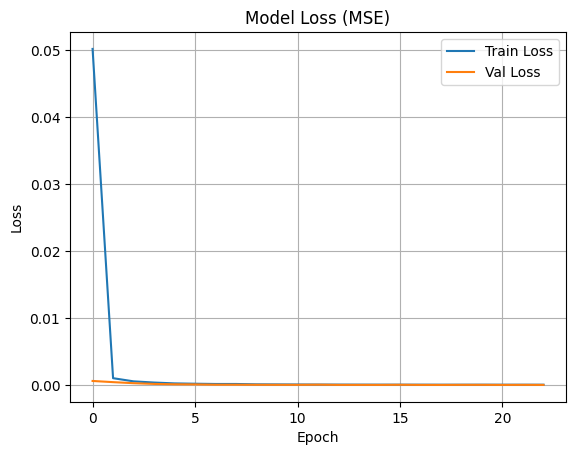

In [28]:
# 1. Build the Keras MLP for regression
model = Sequential([
    Dense(128, input_dim=X_train_r_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Linear output for regression
])

# 2. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# 3. Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Train the model
history = model.fit(
    X_train_r_scaled, y_train_r,
    validation_data=(X_test_r_scaled, y_test_r),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# 5. Evaluate
y_pred_r = model.predict(X_test_r_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
r2 = r2_score(y_test_r, y_pred_r)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()